In [ ]:
!pip install regex tqdm
!pip install diffusers transformers accelerate scipy
!pip install -U xformers
!pip install opencv-python

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install pycocotools matplotlib onnxruntime onnx

## SAM with stable diffusion 2 inpainting model

In [1]:
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

'gdown' is not recognized as an internal or external command,
operable program or batch file.


## stable diffusion model

In [2]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir = "stabilityai/stable-diffusion-2-inpainting"

scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                      scheduler=scheduler,
                                                      revision="fp16",
                                                      torch_dtype=torch.float16)

pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

c:\Users\sabih\anaconda3\envs\inpainting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\sabih\anaconda3\envs\inpainting\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'
Couldn't connect to the Hub: 401 Client Error. (Request ID: Root=1-693e95a1-7c11a2ed4f1e6b03222125ba;b50f6de5-c24c-4ff8-8fe7-2de8d106474a)

Repository Not Found for url: https://huggingface.co/api/models/stabilityai/stable-diffusion-2-inpainting/revision/fp16.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticat

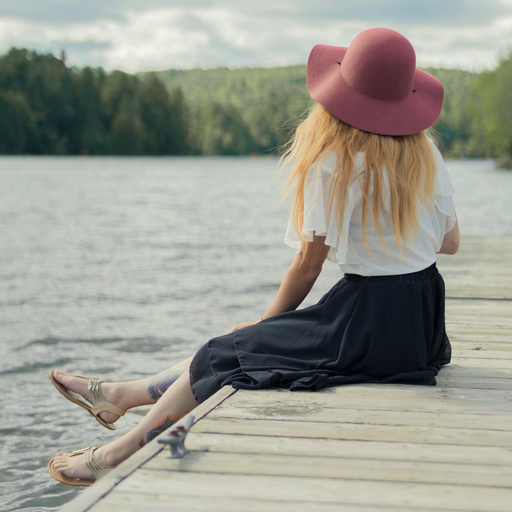

In [4]:
target_width, target_height = 512, 512
source_image = Image.open('images/mix909-AsJirOOLN_s-unsplash.jpg')

width, height = source_image.size

source_image = source_image.crop((0, height-width, width, height))

source_image = source_image.resize((target_width, target_height), Image.LANCZOS)

segmentation_image = np.asarray(source_image)
display(source_image)

In [8]:
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model=sam,
                                           points_per_side=32,
                                           pred_iou_thresh=0.95,
                                           crop_n_layers=1,
                                           crop_n_points_downscale_factor=2,
                                           min_mask_region_area=100)

In [9]:
masks = mask_generator.generate(segmentation_image)

print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())

Number of masks generated: 23
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [10]:
def show_anns(anns):
  if len(anns) == 0:
    return

  sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
  ax = plt.gca()

  ax.set_autoscale_on(False)

  for original_idx, ann in sorted_anns:
    m = ann['segmentation']
    img = np.ones((m.shape[0], m.shape[1], 3))

    color_mask = np.random.random((1, 3)).tolist()[0]

    for i in range(3):
      img[:,:,i] = color_mask[i]

    ax.imshow(np.dstack((img, m*0.35)))

    contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
      cnt = contours[0]
      M = cv2.moments(cnt)

      if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')

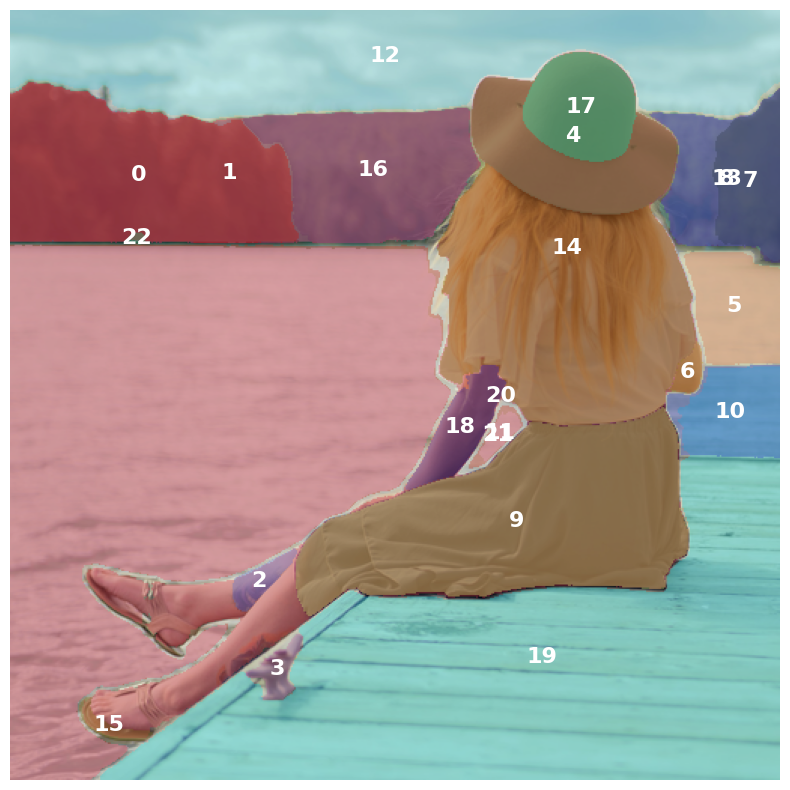

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(source_image)
show_anns(masks[:])
plt.axis('off')
plt.show()

In [12]:
for i, values in enumerate(masks):
  print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")

0: Area: 16196 | IoU: 1.0029146671295166
1: Area: 26579 | IoU: 0.9992243051528931
2: Area: 749 | IoU: 0.967765212059021
3: Area: 684 | IoU: 0.9582074880599976
4: Area: 10627 | IoU: 1.018810510635376
5: Area: 4180 | IoU: 0.9868122339248657
6: Area: 443 | IoU: 0.9759030938148499
7: Area: 3856 | IoU: 0.9740892648696899
8: Area: 6607 | IoU: 0.9660581350326538
9: Area: 21820 | IoU: 1.017009973526001
10: Area: 3886 | IoU: 0.9791845679283142
11: Area: 66738 | IoU: 1.0128151178359985
12: Area: 29822 | IoU: 1.010088324546814
13: Area: 33078 | IoU: 0.9786157608032227
14: Area: 31903 | IoU: 0.9692560434341431
15: Area: 463 | IoU: 0.9515817761421204
16: Area: 10167 | IoU: 0.9886832237243652
17: Area: 4282 | IoU: 0.9799619913101196
18: Area: 2237 | IoU: 0.9770331382751465
19: Area: 54698 | IoU: 1.0328704118728638
20: Area: 64838 | IoU: 1.00527024269104
21: Area: 71427 | IoU: 1.0002244710922241
22: Area: 73 | IoU: 0.9608926773071289


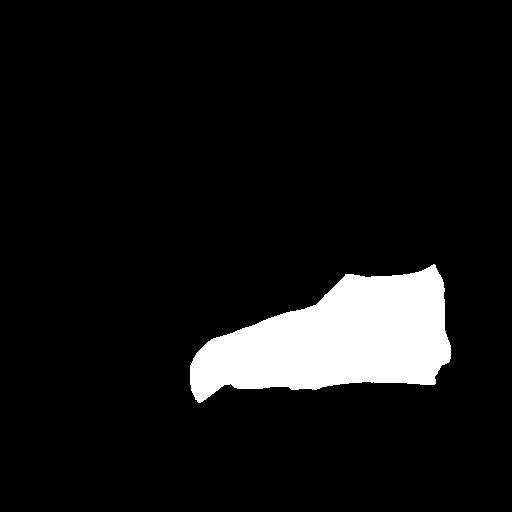

In [13]:
mask_index = 9

segmentation_mask = masks[mask_index]['segmentation']
stable_diffusion_mask = PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)


In [25]:
num_images_per_prompt = 4
inpainting_prompts = ["A yellow flowery skirt", "A skirt with egyptian hieroglyphs", "A skirt with green turtles", "A skirt with beutiful scenery of sunset"]

generator = torch.Generator(device="cuda")

encoded_images = []
for i in range(num_images_per_prompt):
  image = pipe(prompt=inpainting_prompts[i], generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
  encoded_images.append(image)

100%|██████████| 50/50 [00:04<00:00, 10.60it/s]


In [18]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)  # Create a copy of the names list to avoid modifying the external variable
    images = copy.copy(images)  # Create a copy of the images list to avoid modifying the external variable

    # Check if images is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names is equal
        assert images.size(0) == len(names), "Number of images and names should be equal"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names is equal
        assert len(images) == len(names), "Number of images and names should be equal"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"

    # Add the original image to the beginning of the images list
    images.insert(0, original_image)

    # Add an empty name for the original image to the beginning of the names list
    names.insert(0, '')

    # Create a figure with specified rows and columns
    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name)

        # Turn off axes for the subplot
        axes[row, col].axis('off')

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis('off')

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()


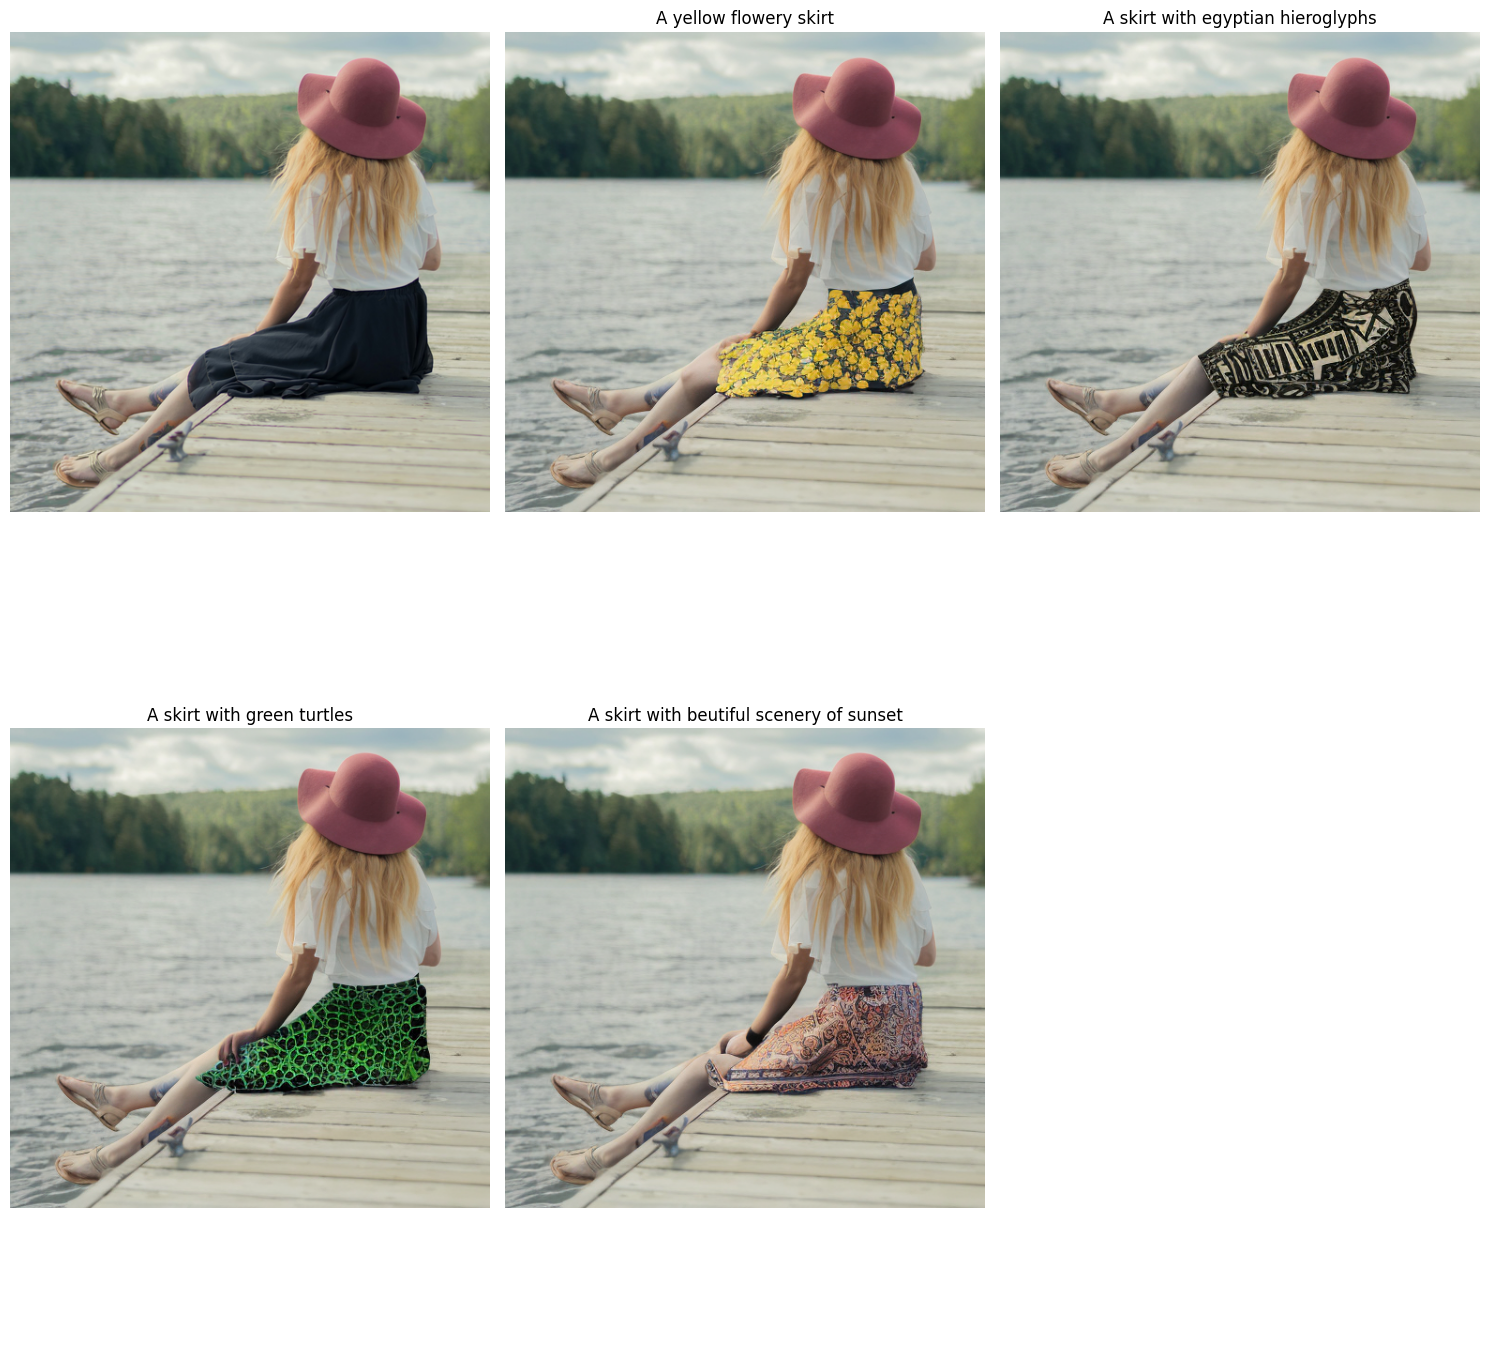

In [27]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)